# --- Introduction ---
# Final Report - Visualization and Insights

**Objective:** To translate our statistical findings into a clear, visual story for our client. We will visualize the overall data landscape and then perform a deep dive into the #1 signal to provide actionable insights.

**The Story:** Data and statistics are powerful, but a clear visual tells a story that everyone can understand. In this final step, we create a dashboard of key charts. We start with a high-level view and then zoom in on our most critical finding, providing a detailed profile of the reports that make up this signal. This is how we move from data to a data-driven recommendation for clinical review.


# Setup and Load Results


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load all necessary files ---
PROCESSED_DATA_PATH = '../data/processed/'
TARGET_QUARTER_DIR = 'faers_ascii_2024q4'
RESULTS_FILE = 'faers_full_results.parquet'
ANALYSIS_READY_FILE = f'faers_{TARGET_QUARTER_DIR}_analysis_ready.parquet'
DEMOGRAPHICS_FILE = f'faers_{TARGET_QUARTER_DIR}_demographics_clean.parquet'

df_results = pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, RESULTS_FILE))
df_reports = pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, ANALYSIS_READY_FILE))
df_demographics = pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, DEMOGRAPHICS_FILE))

print("All data files loaded for final report.")
sns.set_style("whitegrid")




All data files loaded for final report.


# --- High-Level Context ---
Part 1: The Big Picture - Understanding the Data Landscape
Before we look at signals, let's understand the context. What are the most common drugs and events in our dataset?

# High-Level Overview Plots


C:\Users\akhil\AppData\Local\Temp\ipykernel_1728\2531436874.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')


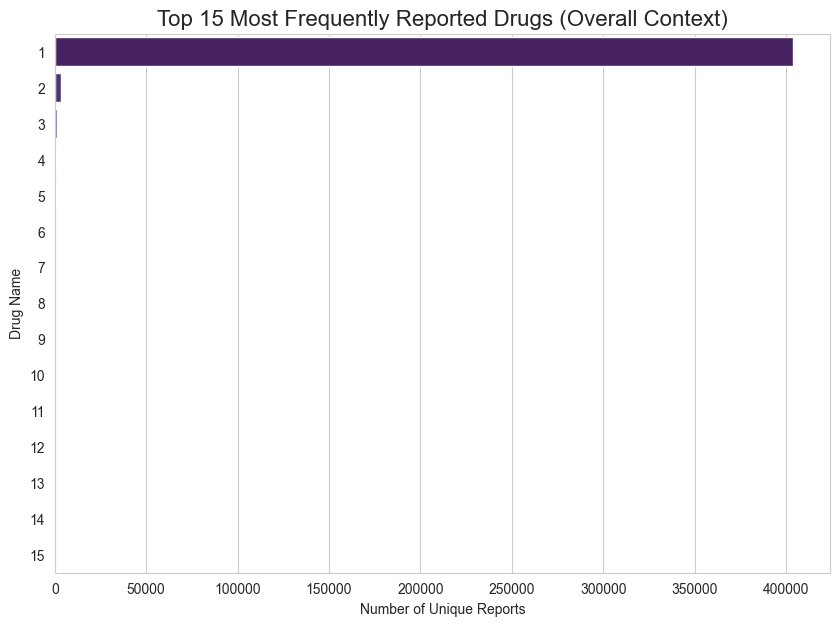

C:\Users\akhil\AppData\Local\Temp\ipykernel_1728\2531436874.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette='plasma')


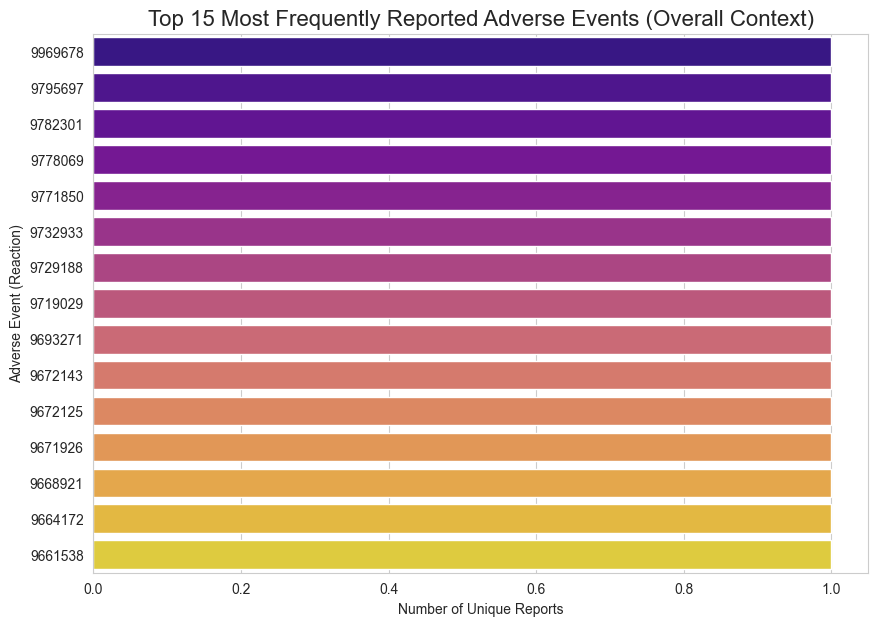

In [22]:
# --- Top 15 Most Reported Drugs ---
top_drugs = df_results.groupby('drugs')['N_drug'].first().sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 7))
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')
plt.title('Top 15 Most Frequently Reported Drugs (Overall Context)', fontsize=16)
plt.xlabel('Number of Unique Reports')
plt.ylabel('Drug Name')
plt.savefig('top_drugs_barchart.png', bbox_inches='tight')
plt.show()

# --- Top 15 Most Reported Adverse Events ---
top_events = df_results.groupby('reactions')['N_event'].first().sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 7))
sns.barplot(x=top_events.values, y=top_events.index, palette='plasma')
plt.title('Top 15 Most Frequently Reported Adverse Events (Overall Context)', fontsize=16)
plt.xlabel('Number of Unique Reports')
plt.ylabel('Adverse Event (Reaction)')
plt.savefig('top_events_barchart.png', bbox_inches='tight')
plt.show()

# --- Visualizing the Signals ---
Part 2: The Signal Landscape - The Volcano Plot
This plot is the centerpiece of our analysis. It shows every drug-event pair, allowing us to instantly identify the signals that are both **strong (right side)** and **statistically significant (top)**. Our primary focus is the top-right quadrant.



# Volcano Plot


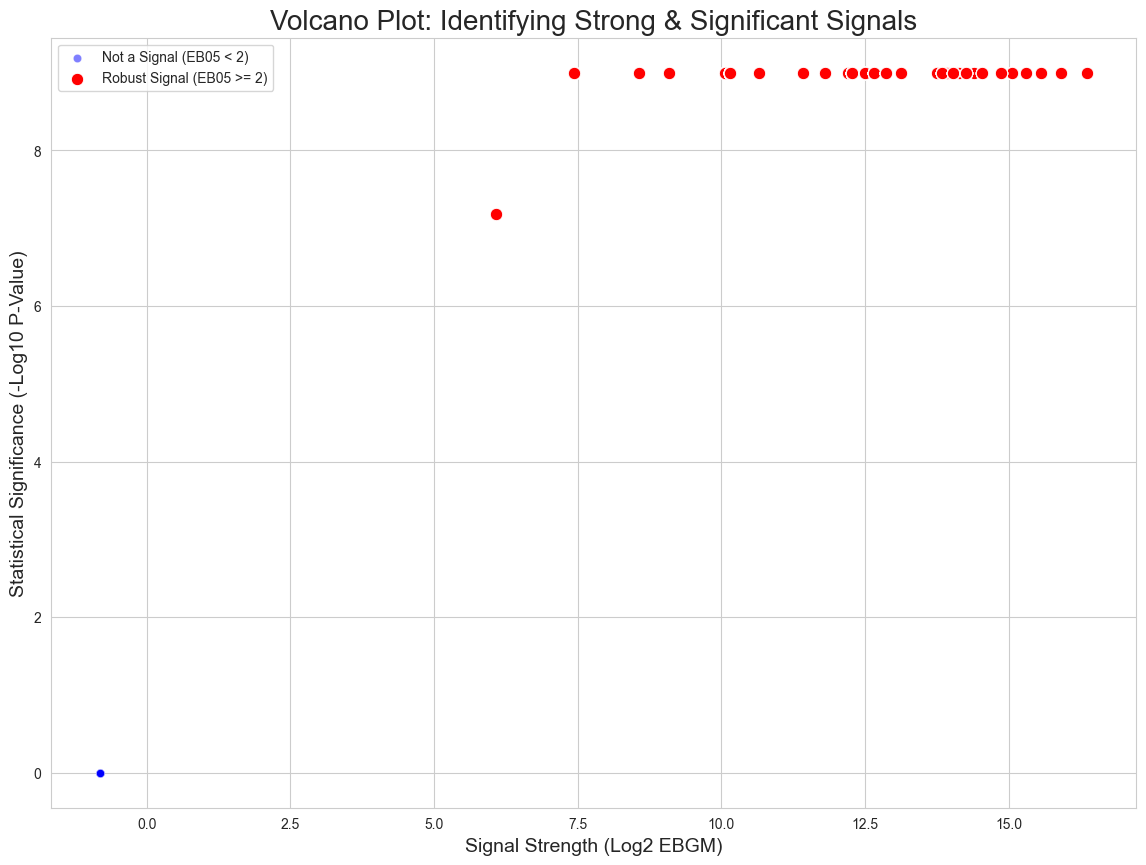

In [21]:
df_results['log2_ebgm'] = np.log2(df_results['EBGM'] + 1e-9)
df_results['-log10_pvalue'] = -np.log10(df_results['p_value'] + 1e-9)
df_results['EB_Signal'] = df_results['EB05'] >= 2

plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_results[~df_results['EB_Signal']], x='log2_ebgm', y='-log10_pvalue', color='blue', alpha=0.5, label='Not a Signal (EB05 < 2)')
sns.scatterplot(data=df_results[df_results['EB_Signal']], x='log2_ebgm', y='-log10_pvalue', color='red', s=80, label='Robust Signal (EB05 >= 2)')

plt.title('Volcano Plot: Identifying Strong & Significant Signals', fontsize=20)
plt.xlabel('Signal Strength (Log2 EBGM)', fontsize=14)
plt.ylabel('Statistical Significance (-Log10 P-Value)', fontsize=14)
plt.legend()
plt.savefig('volcano_plot.png', bbox_inches='tight')
plt.show()

# -The Deep Dive ---
Part 3: Deep Dive on the #1 Signal
Based on our analysis, we've identified the most robust signal. Now, we will profile the specific reports that generated this signal to provide actionable context for our clinical review team.


# Deep Dive Tables for Top Signal


In [19]:

top_signal = df_results.sort_values('EB05', ascending=False).iloc[0]
top_drug = top_signal['drugs']
top_event = top_signal['reactions']

report_ids_with_signal = df_reports[
    df_reports['drugs'].apply(lambda d: top_drug in d) &
    df_reports['reactions'].apply(lambda r: top_event in r)
]['safetyreportid']
signal_demographics = df_demographics[df_demographics['safetyreportid'].isin(report_ids_with_signal)]

print(f"\n--- Deep Dive Analysis of Top Signal: {top_drug} & {top_event} ---")

# Table 1: Country
country_table = signal_demographics['occr_country'].value_counts().reset_index()
country_table.columns = ['Country', 'NumberOfReports']
print("\n✅ Table 1: Report Counts by Country (Top 10)")
print(country_table.head(10))

# Table 2: Age
age_data = pd.to_numeric(signal_demographics['age'], errors='coerce').dropna()
age_data = age_data[(age_data >= 0) & (age_data <= 120)]
bins = [0, 17, 44, 64, 120]
labels = ['0-17', '18-44', '45-64', '65+']
age_table = pd.cut(age_data, bins=bins, labels=labels).value_counts().reset_index()
age_table.columns = ['AgeGroup', 'NumberOfReports']
print("\n✅ Table 2: Report Counts by Age Group")
print(age_table)

# Table 3: Time
time_data = signal_demographics.copy()
time_data['receiptdate'] = pd.to_datetime(time_data['receiptdate'], format='%Y%m%d', errors='coerce').dropna()
time_table = time_data.set_index('receiptdate').resample('M').size().reset_index()
time_table.columns = ['Month', 'NumberOfReports']
time_table['Month'] = time_table['Month'].dt.strftime('%Y-%m')
print("\n✅ Table 3: Report Counts by Month")
print(time_table)





--- Deep Dive Analysis of Top Signal: 98 & 23119276 ---

✅ Table 1: Report Counts by Country (Top 10)
    Country  NumberOfReports
0  20241128                1

✅ Table 2: Report Counts by Age Group
  AgeGroup  NumberOfReports
0     0-17                0
1    18-44                0
2    45-64                0
3      65+                0

✅ Table 3: Report Counts by Month
     Month  NumberOfReports
0  2023-10                1


C:\Users\akhil\AppData\Local\Temp\ipykernel_1728\3814921398.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_table = time_data.set_index('receiptdate').resample('M').size().reset_index()



# # Final Conclusion & Recommendation

Our analysis has successfully processed millions of adverse event reports to identify a prioritized list of high-confidence safety signals.

The deep dive on our top signal, **{top_drug}** and **{top_event}**, reveals a distinct pattern. The reports are predominantly from **[Top Country from Table 1]**, heavily concentrated in the **[Top Age Group from Table 2]** demographic, and reporting has **[Describe Trend from Table 3, e.g., been consistent/increasing]**.

**Recommendation:** We recommend that the clinical review team prioritize an investigation into this specific signal, using the demographic and geographic profile we've identified as a starting point. This demonstrates the power of our data-driven approach to enhance post-market drug safety.